In [1]:
from qiskit_aer.primitives import Estimator
from qiskit_aer import AerSimulator 
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector, random_clifford, state_fidelity
from tomography import SelfGuidedTomography, Mean_Direct_Fidelity, NearSparseTomography, NearSparseTomography_v2

In [2]:
from qiskit_aer.noise import NoiseModel, depolarizing_error 
error_1 = depolarizing_error( 1e-3, 1 )
error_2 = depolarizing_error( 1e-2, 2 )
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h', 's', 'sd', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [3]:
NQs = [2,3,4]
L = len(NQs)
N = 4
rank = 2 
shots = 1000
num_iter = 10

simulator_ideal=Estimator(backend_options={'shots':shots,
                                            'method':"stabilizer",
                                            'noise_model':noise_model,
                                            },
                            transpile_options={'optimization_level':0},
                            ) 

In [4]:
from joblib import Parallel, delayed

def simulate( NQ, simulator ):

    d = 2**NQ

    Omega  = random_clifford( NQ ).to_circuit()
    # OmegaS = np.array( Statevector(Omega) )
    # OmegaM = .5*np.outer( OmegaS, OmegaS.conj() ) 

    #####
    qasm = AerSimulator(method='density_matrix',
                        noise_model=noise_model)
    Omega_density = Omega.copy()
    Omega_density.save_density_matrix()
    OmegaM_noisy = np.array( qasm.run(Omega_density).result().data()['density_matrix'] )
    #####

    I_th = lambda x: 1 - np.vdot( x, OmegaM_noisy@x )/(np.linalg.norm( x ))**2

    Fidelities = []
    Measures = []
    Last=[]
    def callback( i, x ):
        Last.append(x)
        Fidelities.append( I_th(x) )
        Measures.append(len(MDF.Measures))
        return None

    # first level 
    psi0 = np.random.rand(d) + 1j * np.random.rand(d)
    psi0 = psi0 / np.linalg.norm(psi0)
    guess = psi0 

    MDF = Mean_Direct_Fidelity(NQ)

    stop_measuring = lambda x : ( np.linalg.norm( list( x.values() ) ) > 0.99 )

    I_ex = lambda x : 1 - MDF.MeanFidelity(1, 
                                        2*NQ**2, 
                                        x,
                                        Omega,
                                        simulator,
                                        truncation= None,
                                        stop_measuring = stop_measuring,
                                        )

    postprocessing = lambda x : NearSparseTomography( x, MDF=MDF )

    SelfGuidedTomography( I_ex, 
                            guess, 
                            num_iter=num_iter, 
                            callback = callback,
                            postprocessing = postprocessing,
                            )
    
    #tomography for a mixed state
    phi_in = np.eye( MDF.d, rank-1 )
    rho_out = NearSparseTomography_v2( phi_in, Last[-1], 1-Fidelities[-1], MDF ) 

    Results=[np.array(Fidelities), 
                np.array(Measures), 
                np.array(Last),
                state_fidelity( rho_out, OmegaM_noisy )
                ] 

    return Results  #j index the average over the Hilbert space 


In [5]:
from itertools import chain
R = []
# Iterar sobre cada valor en NQs
for NQ in NQs:
    Data0 = Parallel(n_jobs=-1, verbose=11)(
        delayed(simulate)(NQ, simulator_ideal) for _ in range(N))    
    R.append(Data0) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished


In [6]:
Fids = []
Meas = []
Mix  = []

for l, NQ in enumerate(NQs):
    Fids_n = []
    Meas_n = []
    Mix_n  = []
    for n in range(N):
        Fids_n.append( R[l][n][0] )
        Meas_n.append( R[l][n][1] )
        Mix_n.append( R[l][n][-1] )
    Fids.append( Fids_n )
    Meas.append( Meas_n )
    Mix.append( Mix_n )

Fids = np.mean( Fids, axis=1 ).real
Meas = np.mean( Meas, axis=1 ).real
Mix  = np.mean( Mix, axis=1 )

In [7]:
1-Mix, Fids[:,-1] 

(array([0.01192301, 0.0438936 , 0.09295333]),
 array([0.01264349, 0.03169673, 0.06653417]))

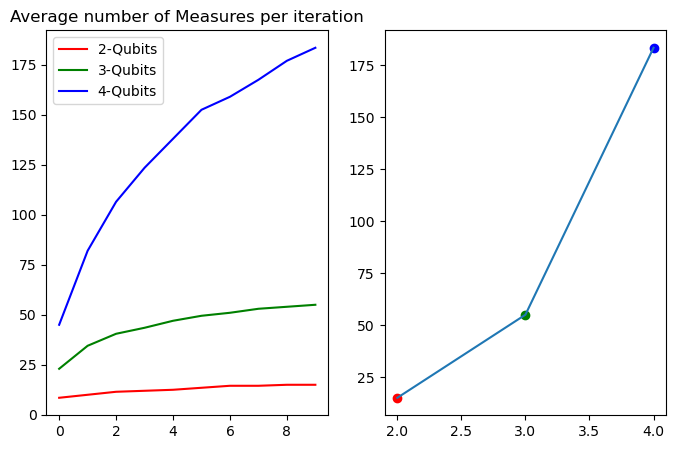

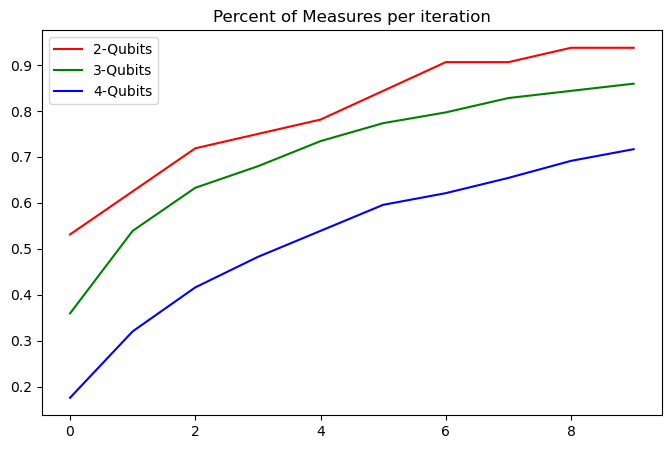

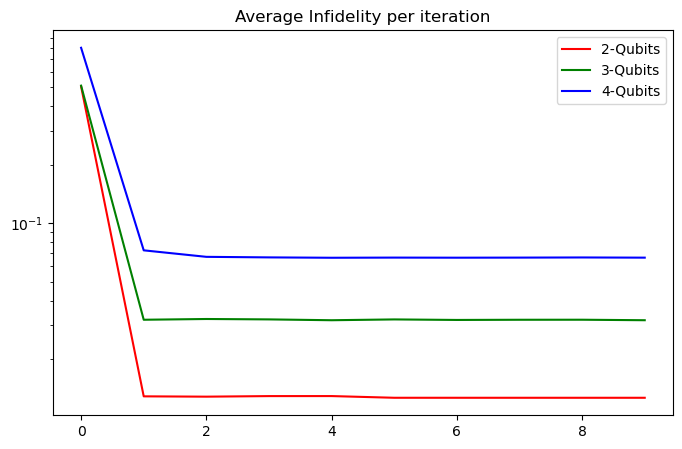

In [8]:

import matplotlib.pyplot as plt

x = NQs 
y = [ meas[-1] for meas in Meas ] 
coef = np.polyfit( x, y, 2 )

# Lista de colores arbitrarios
colores = ['r', 'g', 'b', 'orange', 'purple']

# Crear primer conjunto de gráficos para Measures
fig0, ax0 = plt.subplots(1,2, figsize=(8, 5))
ax0[0].set_title('Average number of Measures per iteration')

for j in range(len(NQs)):
    ax0[0].plot(Meas[j], label=f'{NQs[j]}-Qubits', 
                linestyle='-', color=colores[j])
    ax0[1].plot(j+2,Meas[j][-1], 
                'o',
                label=f'{NQs[j]}-Qubits', 
                color=colores[j])
ax0[1].plot( x, np.polyval(coef,x)  ) 

    # ax1.axhline( 4**NQs[j], color=colores[j], linestyle='--' )
ax0[0].legend() 
# Guardar el primer conjunto de gráficos
# fig0.savefig('Measures.png')

# Crear primer conjunto de gráficos para Measures
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title('Percent of Measures per iteration')

for j in range(len(NQs)):
    ax1.plot(Meas[j]/4**NQs[j], label=f'{NQs[j]}-Qubits', 
                linestyle='-', color=colores[j])
    # ax1.axhline( 4**NQs[j], color=colores[j], linestyle='--' )
ax1.legend() 
# Guardar el primer conjunto de gráficos
# fig1.savefig('Measures.png')

# Crear segundo conjunto de gráficos para Measures
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_title('Average Infidelity per iteration')

for j in range(len(NQs)):
    ax2.semilogy( Fids[j], label=f'{NQs[j]}-Qubits', 
                    linestyle='-', color=colores[j])

ax2.legend()
# Guardar el segundo conjunto de gráficos
# fig2.savefig('Fidelities.png')
    